In [ ]:
# References 
# https://scikit-learn.org/stable/
# https://keras.io/
# Deep Learning Course

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


First, download the dataset from the following link as .zip file:

https://academictorrents.com/details/7a638ed187a6180fd6e464b3666a6ea0499af4af

Then, extract the zip file into a folder. You can then upload this dataset to your google drive folder or use it on any platform you want.

For more information about dataset, you can see this article:
The Article: https://arxiv.org/abs/1912.12142


## Downloading and Saving Dataset

Once you have saved the data and labels into a folder, you can call them from the related folder and use them in any way you want.

#Call data from directory

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

file_dir = "/content/drive/MyDrive/Deep Learning/"
data = np.load(file_dir + "data120.npy")
labels = np.load(file_dir + "labels120.npy", allow_pickle=True)
print(labels)

['Colon adenocarcinoma' 'Colon adenocarcinoma' 'Colon adenocarcinoma' ...
 'Lung Squamous Cell Carcinoma' 'Lung Squamous Cell Carcinoma'
 'Lung Squamous Cell Carcinoma']


# Preprocessing and EDA (Exploratory Data Analysis)


## Converting the Target Values to the One-Hot-Encoded Format

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#to use one hot encoding for the labels we have to convert first the label in integer
label_encoder = LabelEncoder()
label_int = label_encoder.fit_transform(labels)
#one hot encoding
labels_encoded = to_categorical(label_int)


## Visualizing Sample Images

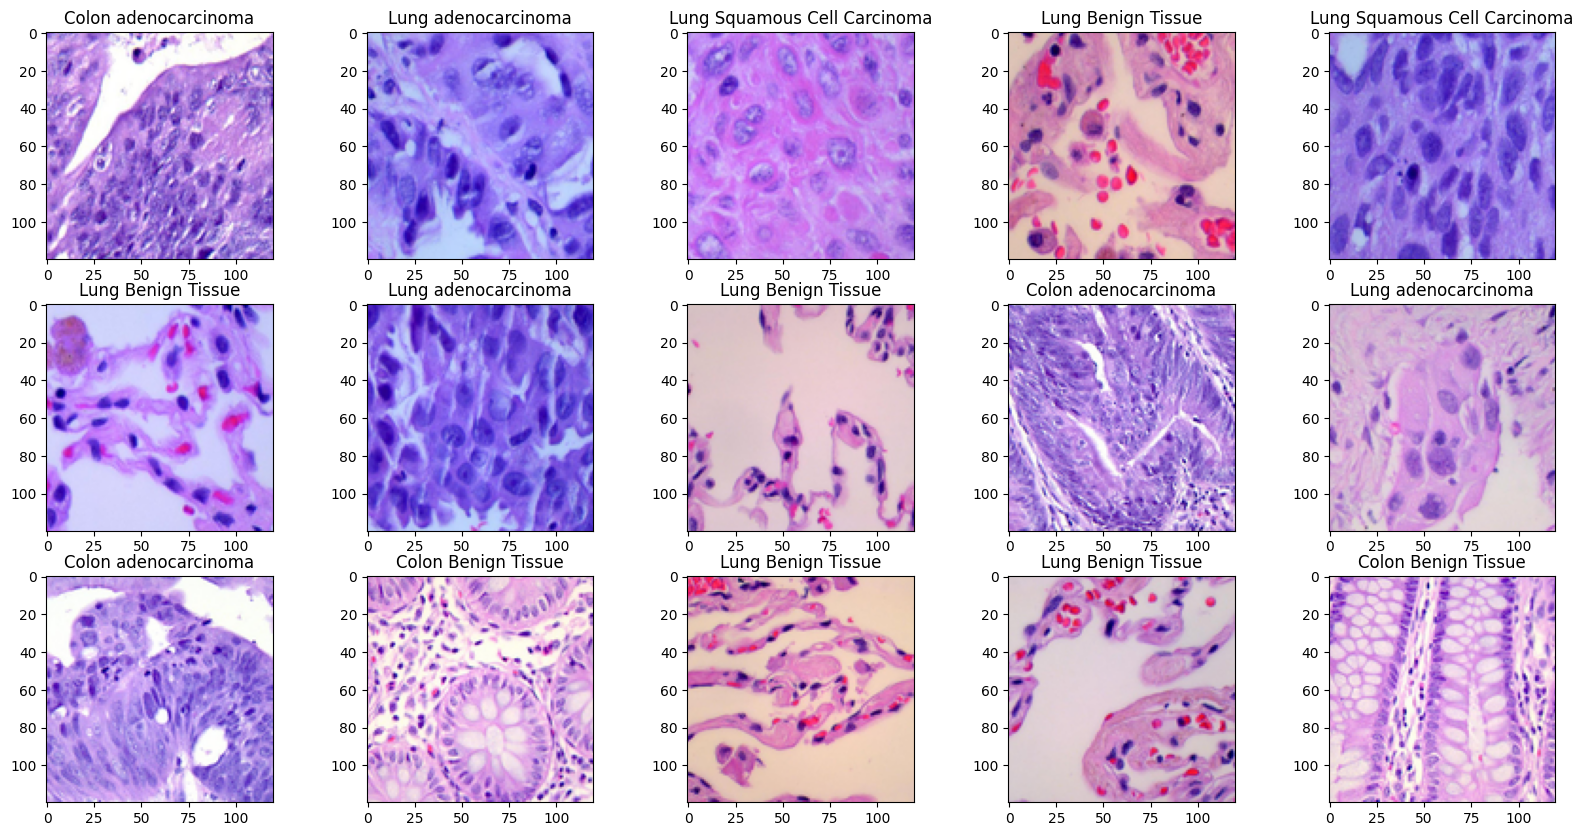

In [15]:
import matplotlib.pyplot as plt

#randomly selecting 15 images
random_int = np.random.randint(0,data.shape[0], 15)
random_sample = data[random_int]
sample_labels = labels[random_int]

#create a figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(20,10))
#Flattening the axes so we can iterate over them in a simple loop, instead of using nested loops.
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.imshow(random_sample[i])
    ax.set_title(sample_labels[i])

plt.show()



## Visualizing Class Distribution

{'Colon Benign Tissue': 5000, 'Colon adenocarcinoma': 5000, 'Lung Benign Tissue': 5000, 'Lung Squamous Cell Carcinoma': 5000, 'Lung adenocarcinoma': 5000}


Text(0, 0.5, 'number of images')

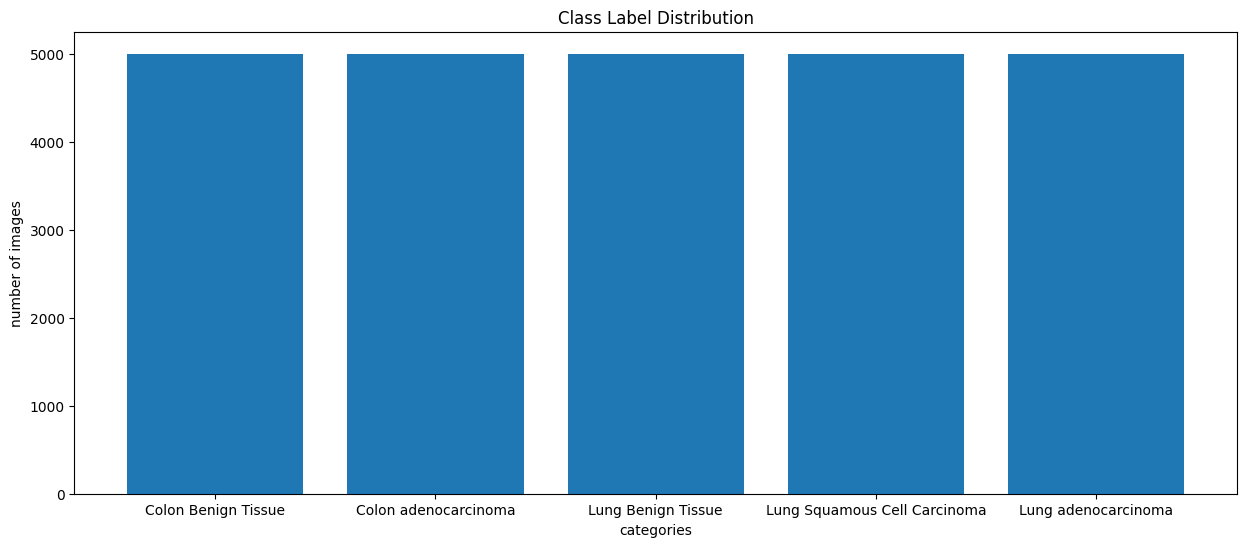

In [16]:
#Creating bar plot for the class label distribution of the dataset

#creating a dictionary of the occurences of each unique label
unique_labels = np.unique(labels)
label_distr = {}
for i in unique_labels:
    label_distr[i]=np.count_nonzero(labels==i)
print(label_distr)

#Bar plot
plt.figure(figsize=(15, 6))
plt.bar(label_distr.keys(), label_distr.values())
plt.title("Class Label Distribution")
plt.xlabel("categories")
#plt.xticks(rotation=45, ha="right")
plt.ylabel("number of images")

##Train-Test-Val Split

In [17]:
from sklearn.model_selection import train_test_split
#Splitting the original dataset into 60% for training, 20% for validation and 20% for testing


#First split with 80% for training and 20% for test
X_train_val, X_test, y_train_val, y_test = train_test_split(data, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

#second split where from the remaining 80% we will get one set for training and one for validation
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Evaluation Functions

Since you will use the same evaluation functions several times ( to evaluate the baseline, enhanced and transfer learning models), it is better to prepare the standardized functions to calculate them each time in the same way.

In [18]:
## LOSS-ACC GRAPHS for training and evaluation
def loss_acc_graphs(history):

    #Training/Validation Accuracy
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()


In [19]:
#Conf matrix and Classification Report:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, class_labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    acc = accuracy_score(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    print(f'{title} Accuracy: {acc:.3f}')

    # Plot the confusion matrix
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma', yticklabels=class_labels)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

In [20]:
#ROC curves
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

def plot_roc_curves(y_true, y_score, n_classes, title='Receiver Operating Characteristic'):
    # Calculate the ROC curve and AUC for each class
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10, 5))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'pink', 'lightblue', 'lightgreen'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    plt.plot(fpr["micro"], tpr["micro"], label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"], label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()



In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score

#This function calculates precision, recall, and F1 score between true and predicted labels.
def calculate_metrics(y_true, y_pred, average='macro'):
    # Converting probabilities to class labels
    y_pred_labels = y_pred.argmax(axis=1)
    y_true_labels = y_true.argmax(axis=1)

    precision = precision_score(y_true_labels, y_pred_labels, average=average)
    recall = recall_score(y_true_labels, y_pred_labels, average=average)
    f1 = f1_score(y_true_labels, y_pred_labels, average=average)

    return precision, recall, f1

# Baseline Model

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Create a sequential model
model = Sequential()

# Add convolutional and pooling layers
#we will use padding="same" so our width and height remain the same
model.add(layers.Conv2D(128, (3,3), activation="relu", input_shape= X_train.shape[1:], padding='same')) #input shape is (120, 120, 3) which is height x width x channels
model.add(layers.MaxPooling2D((2,2)) )
model.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same' ))
model.add(layers.MaxPooling2D((2,2)) )
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu" ))
model.add(layers.Dense(32, activation = "relu" ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
model.add(layers.Dense(5, activation='softmax'))


model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dense_3 (Dense)             (None, 128)              

In [23]:
model.compile(optimizer="Adam", metrics = ["accuracy"], loss="categorical_crossentropy" )
history = model.fit(X_train, y_train, epochs= 10, batch_size = 32, validation_data = (X_val, y_val) )
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/10
469/469 [==============================] - 18s 34ms/step - loss: 2.6800 - accuracy: 0.6062 - val_loss: 0.6612 - val_accuracy: 0.6788
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - loss: 0.5948 - accuracy: 0.7028 - val_loss: 0.5359 - val_accuracy: 0.7322
Epoch 3/10
469/469 [==============================] - 15s 33ms/step - loss: 0.5590 - accuracy: 0.7231 - val_loss: 0.5460 - val_accuracy: 0.7396
Epoch 4/10
469/469 [==============================] - 15s 33ms/step - loss: 0.5077 - accuracy: 0.7573 - val_loss: 0.5056 - val_accuracy: 0.7638
Epoch 5/10
469/469 [==============================] - 17s 35ms/step - loss: 0.4708 - accuracy: 0.7769 - val_loss: 0.7520 - val_accuracy: 0.7186
Epoch 6/10
469/469 [==============================] - 15s 32ms/step - loss: 0.4962 - accuracy: 0.7620 - val_loss: 0.5762 - val_accuracy: 0.7638
Epoch 7/10
469/469 [==============================] - 15s 32ms/step - loss: 0.4518 - accuracy: 0.7945 - val_loss: 0.6528 - val_accuracy:

Analyze the performance of the baseline by plotting

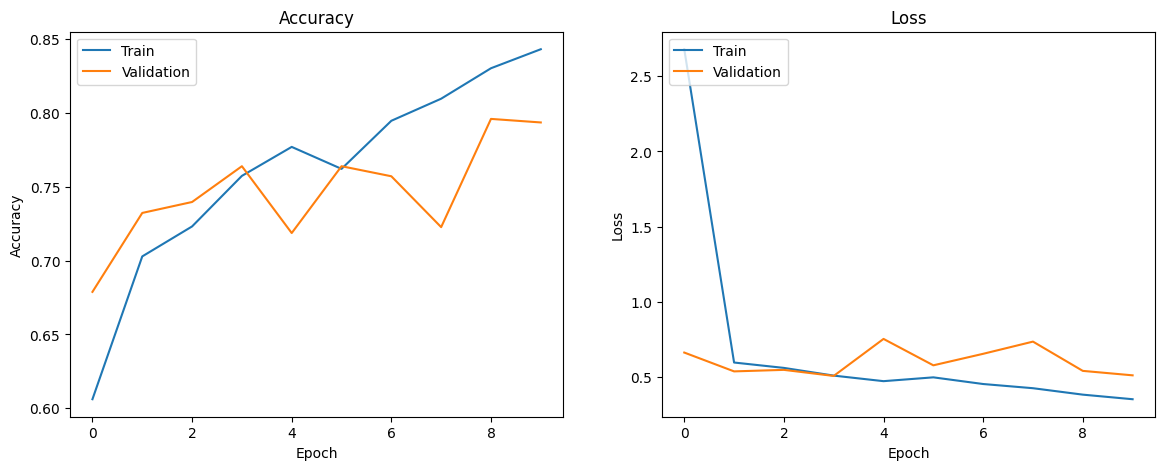

In [24]:
# Plot training & validation Loss - Accuracy values
loss_acc_graphs(history)

157/157 [==============================] - 1s 8ms/step


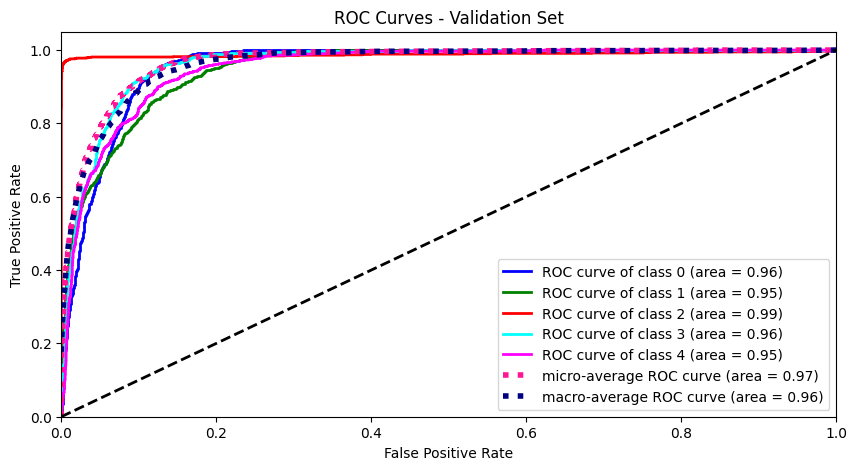

In [25]:
# ---------------- ROC Curve for validation set ----------------

# calculating the predicted probabilities for each class
y_score_val = model.predict(X_val)
#number of classes
n_classes = y_val.shape[1]

plot_roc_curves(y_val, y_score_val, n_classes, title='ROC Curves - Validation Set')
#AUC values range from 0 to 1, with a higher AUC indicating a better model performance

157/157 [==============================] - 1s 7ms/step


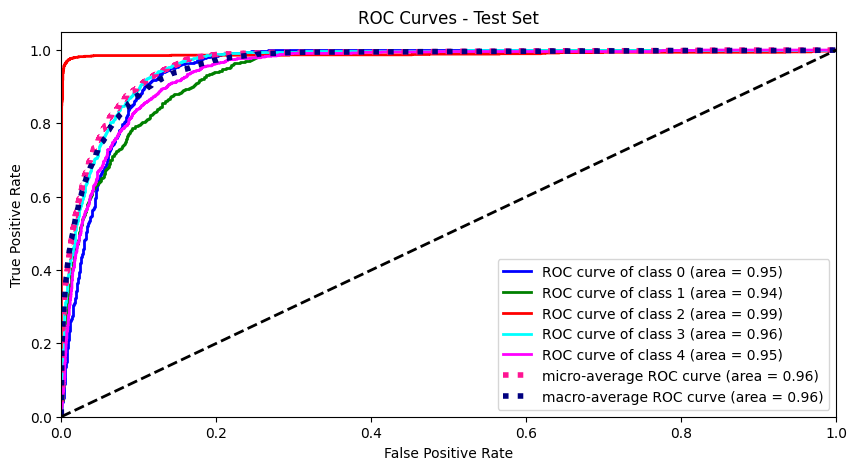

In [26]:
# ---------------- ROC Curve for Test set ----------------

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

y_score_test = model.predict(X_test)
#number of classes
n_classes = y_test.shape[1]
plot_roc_curves(y_test, y_score_test, n_classes, title='ROC Curves - Test Set')


Confusion Matrix - Validation Set Accuracy: 0.793


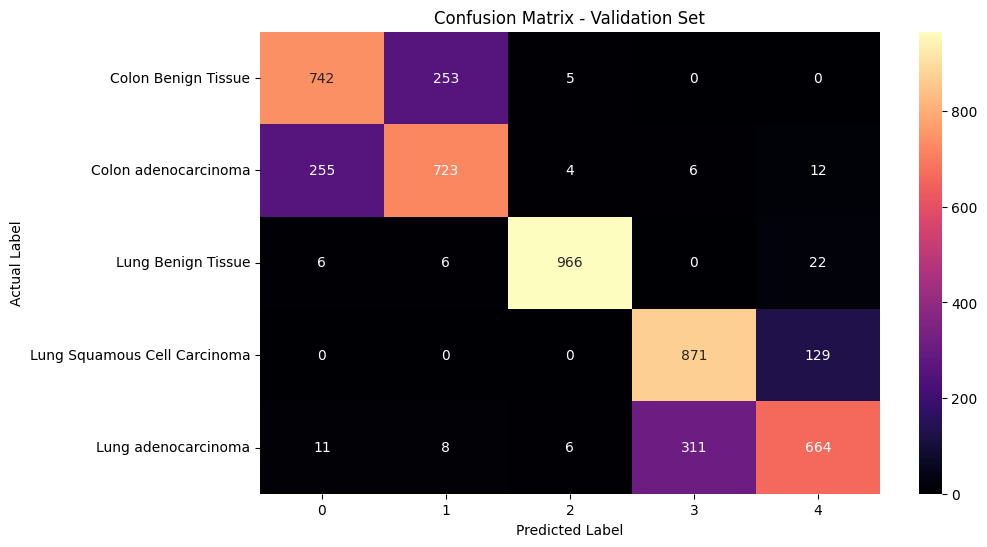

In [27]:
# ----------- Confusion Matrix for Validation Set -----------

y_pred = (y_score_val > 0.5)
plot_confusion_matrix(y_val, y_pred, label_encoder.classes_, title='Confusion Matrix - Validation Set')

In [28]:
# Evaluation Metrics for validation set
precision_val, recall_val, f1_val = calculate_metrics(y_val, y_score_val)
print(f'Validation - Precision: {precision_val:.3f}, Recall: {recall_val:.3f}, F1 Score: {f1_val:.3f}')

Validation - Precision: 0.797, Recall: 0.793, F1 Score: 0.793


Confusion Matrix - Test Set Accuracy: 0.782


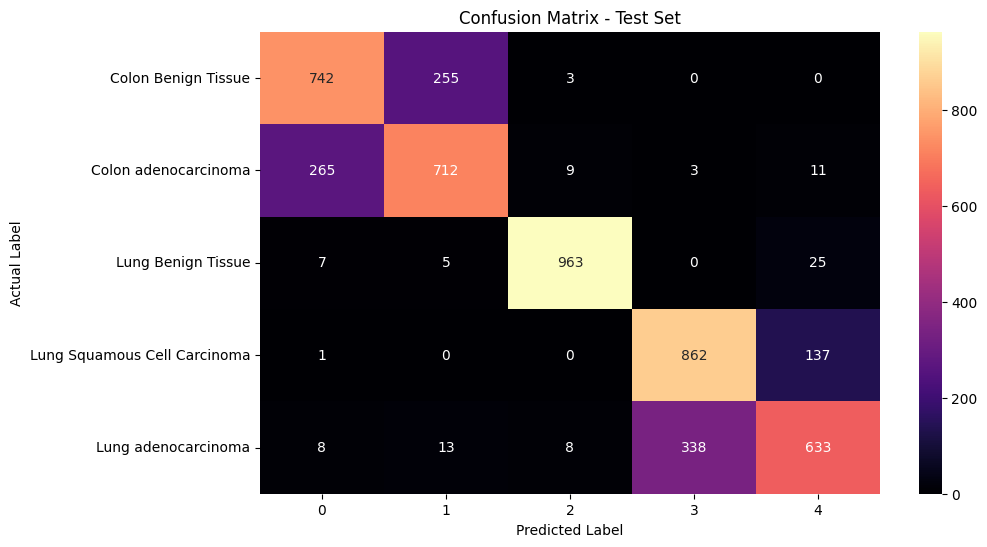

In [29]:
# ----------- Confusion Matrix for Test Set -----------

y_pred = (y_score_test > 0.5)
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, title='Confusion Matrix - Test Set')

In [30]:
# Evaluation Metrics for test set
precision_test, recall_test, f1_test = calculate_metrics(y_test, y_score_test)
print(f'Test - Precision: {precision_test:.3f}, Recall: {recall_test:.3f}, F1 Score: {f1_test:.3f}')

Test - Precision: 0.788, Recall: 0.784, F1 Score: 0.783


# Enhanced Model

In [31]:
# After thorough experimentation with the hyperparameters we will apply:
# l2 wich copes best with overfitting + 
# learning rate and adamax optimizer + 
# more layers + 
# more neurons (pyramid architecture) + 
# tanh as activation function + 
# early stopping + 
# more epochs

from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Defining the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Create a sequential model
model_layers = Sequential()
regularizer = regularizers.l2(0.0001)

# Add convolutional and pooling layers
model_layers.add(layers.Conv2D(64, (3,3), activation="tanh", input_shape = X_train.shape[1:], padding='same', kernel_regularizer = regularizer)) #input shape is (120, 120, 3) which is height x width x channels
model_layers.add(layers.Conv2D(64, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(128, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(128, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(512, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(512, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Flatten())
model_layers.add(layers.Dense(128, activation = "tanh", kernel_regularizer = regularizer ))
model_layers.add(layers.Dense(64, activation = "tanh", kernel_regularizer = regularizer ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
model_layers.add(layers.Dense(5, activation='softmax'))


model_layers.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 120, 120, 64)      1792      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                 

Epoch 1/20
469/469 [==============================] - 84s 141ms/step - loss: 0.7215 - accuracy: 0.8087 - val_loss: 0.6005 - val_accuracy: 0.8674
Epoch 2/20
469/469 [==============================] - 58s 124ms/step - loss: 0.5515 - accuracy: 0.8835 - val_loss: 0.4478 - val_accuracy: 0.9222
Epoch 3/20
469/469 [==============================] - 63s 134ms/step - loss: 0.4901 - accuracy: 0.9047 - val_loss: 0.5329 - val_accuracy: 0.8940
Epoch 4/20
469/469 [==============================] - 59s 125ms/step - loss: 0.4433 - accuracy: 0.9217 - val_loss: 0.4176 - val_accuracy: 0.9362
Epoch 5/20
469/469 [==============================] - 63s 133ms/step - loss: 0.4100 - accuracy: 0.9325 - val_loss: 0.4233 - val_accuracy: 0.9256
Epoch 6/20
469/469 [==============================] - 63s 134ms/step - loss: 0.3809 - accuracy: 0.9427 - val_loss: 0.3555 - val_accuracy: 0.9490
Epoch 7/20
469/469 [==============================] - 63s 134ms/step - loss: 0.3455 - accuracy: 0.9561 - val_loss: 0.3539 - val_ac

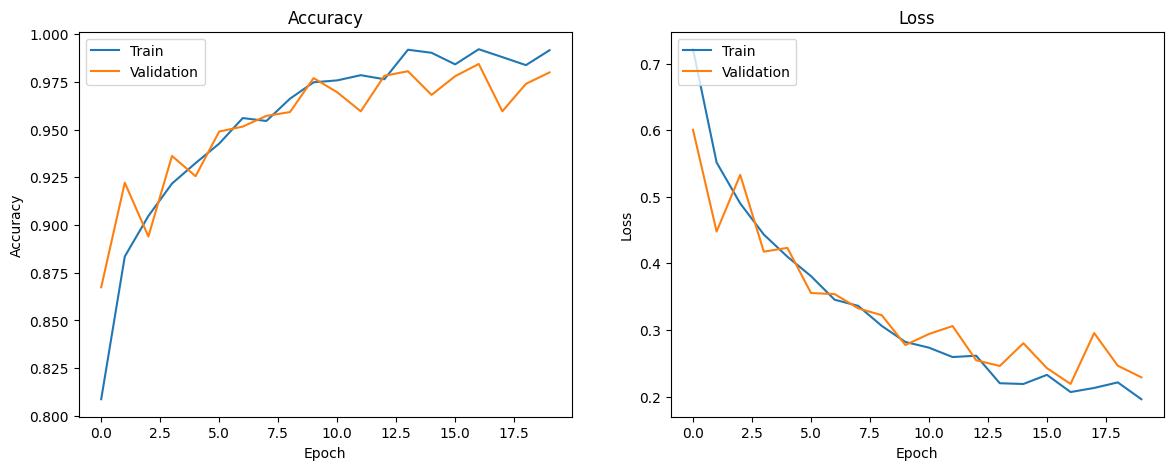

In [32]:
from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0001)

model_layers.compile(optimizer=adam_optimizer, metrics = ["accuracy"], loss="categorical_crossentropy" )
model_layers_hist = model_layers.fit(X_train, y_train, epochs= 20, batch_size = 32, validation_data = (X_val, y_val), callbacks=[early_stopping] )
test_loss, test_acc = model_layers.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_layers_hist)

157/157 [==============================] - 6s 36ms/step


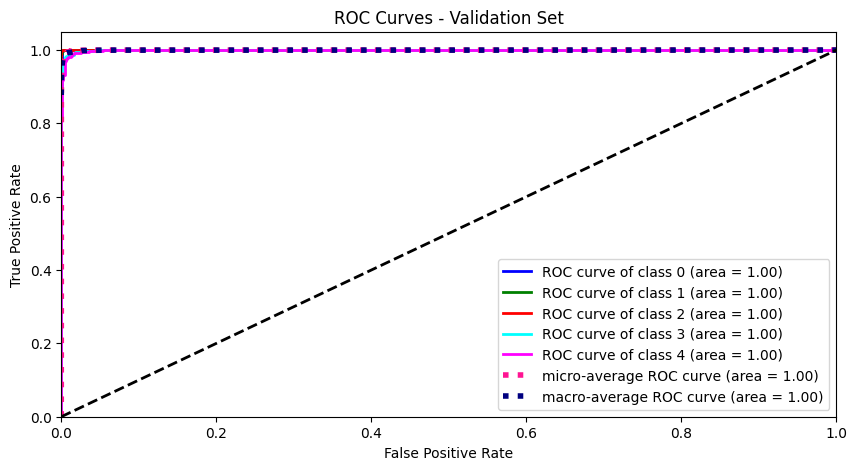

In [33]:
# ---------------- ROC Curve for validation set ----------------

# calculating the predicted probabilities for each class
y_score_val = model_layers.predict(X_val)
#number of classes
n_classes = y_val.shape[1]

plot_roc_curves(y_val, y_score_val, n_classes, title='ROC Curves - Validation Set')
#AUC values range from 0 to 1, with a higher AUC indicating a better model performance

157/157 [==============================] - 6s 36ms/step


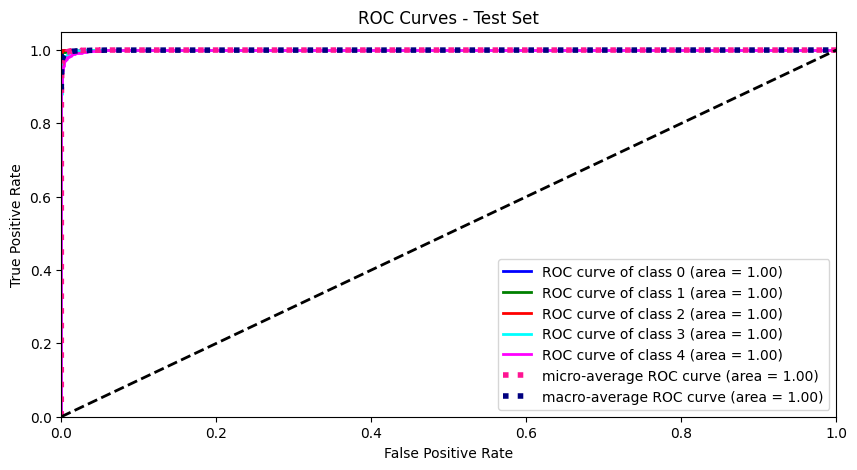

In [34]:
# ---------------- ROC Curve for Test set ----------------

y_score_test = model_layers.predict(X_test)
#number of classes
n_classes = y_test.shape[1]
plot_roc_curves(y_test, y_score_test, n_classes, title='ROC Curves - Test Set')


Confusion Matrix - Validation Set Accuracy: 0.984


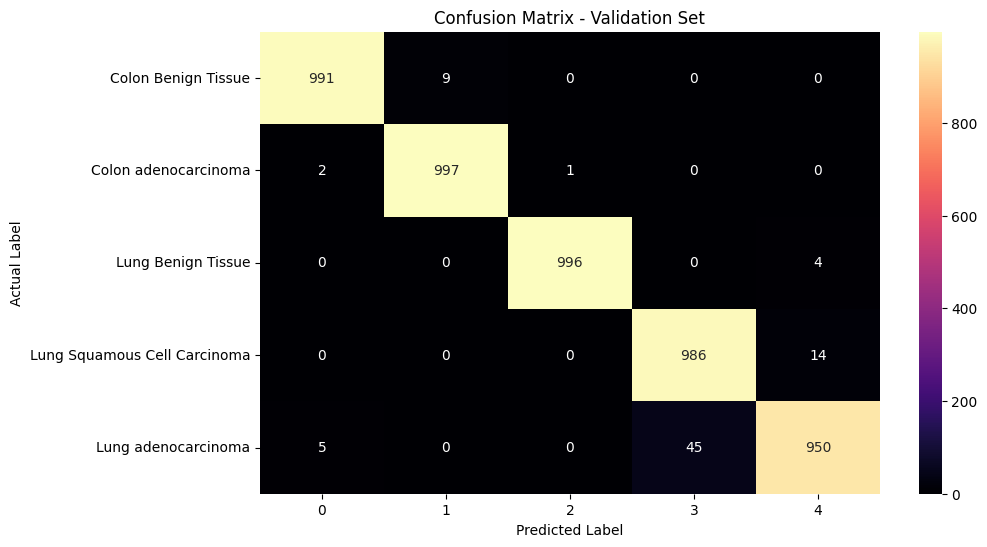

In [35]:
# ----------- Confusion Matrix for Validation Set -----------

y_pred = (y_score_val > 0.5)
plot_confusion_matrix(y_val, y_pred, label_encoder.classes_, title='Confusion Matrix - Validation Set')

In [36]:
# Evaluation Metrics for validation set
precision_val, recall_val, f1_val = calculate_metrics(y_val, y_score_val)
print(f'Validation - Precision: {precision_val:.3f}, Recall: {recall_val:.3f}, F1 Score: {f1_val:.3f}')

Validation - Precision: 0.985, Recall: 0.984, F1 Score: 0.984


Confusion Matrix - Test Set Accuracy: 0.988


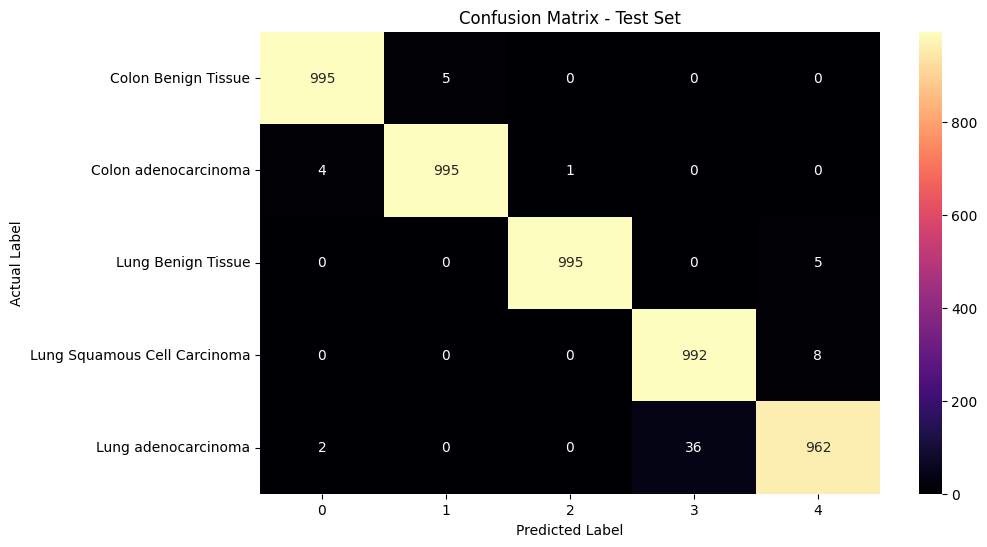

In [37]:
# ----------- Confusion Matrix for Test Set -----------

y_pred = (y_score_test > 0.5)
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, title='Confusion Matrix - Test Set')

In [38]:
# Evaluation Metrics for test set
precision_test, recall_test, f1_test = calculate_metrics(y_test, y_score_test)
print(f'Test - Precision: {precision_test:.3f}, Recall: {recall_test:.3f}, F1 Score: {f1_test:.3f}')

Test - Precision: 0.988, Recall: 0.988, F1 Score: 0.988


# Transfer Learning Model


In [39]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Sequential, layers, regularizers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Load VGG16 pre-trained on ImageNet, without the top layer
#ImageNet dataset is a large dataset used for training various deep learning models in image recognition tasks.
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(120, 120, 3))

# Freeze the layers of VGG16
for layer in vgg_base.layers:
    layer.trainable = False

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Create a sequential model and add the VGG16 base model
model = Sequential([
    vgg_base,  # Add the VGG16 base model as the first layer
    layers.Flatten(),
    layers.Dense(128, activation='tanh', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dense(64, activation='tanh', kernel_regularizer=regularizers.l2(0.0001)),
    layers.Dense(5, activation='softmax')
])

58889256/58889256 [==============================] - 0s 0us/step


In [40]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)

Epoch 1/20
469/469 [==============================] - 33s 63ms/step - loss: 0.5018 - accuracy: 0.8412 - val_loss: 0.2722 - val_accuracy: 0.9210
Epoch 2/20
469/469 [==============================] - 25s 54ms/step - loss: 0.2017 - accuracy: 0.9461 - val_loss: 0.1982 - val_accuracy: 0.9438
Epoch 3/20
469/469 [==============================] - 25s 54ms/step - loss: 0.1403 - accuracy: 0.9671 - val_loss: 0.1626 - val_accuracy: 0.9518
Epoch 4/20
469/469 [==============================] - 29s 63ms/step - loss: 0.1060 - accuracy: 0.9773 - val_loss: 0.1458 - val_accuracy: 0.9574
Epoch 5/20
469/469 [==============================] - 29s 63ms/step - loss: 0.0818 - accuracy: 0.9855 - val_loss: 0.1375 - val_accuracy: 0.9600
Epoch 6/20
469/469 [==============================] - 25s 54ms/step - loss: 0.0681 - accuracy: 0.9895 - val_loss: 0.1297 - val_accuracy: 0.9628
Epoch 7/20
469/469 [==============================] - 29s 63ms/step - loss: 0.0550 - accuracy: 0.9935 - val_loss: 0.1281 - val_accuracy:

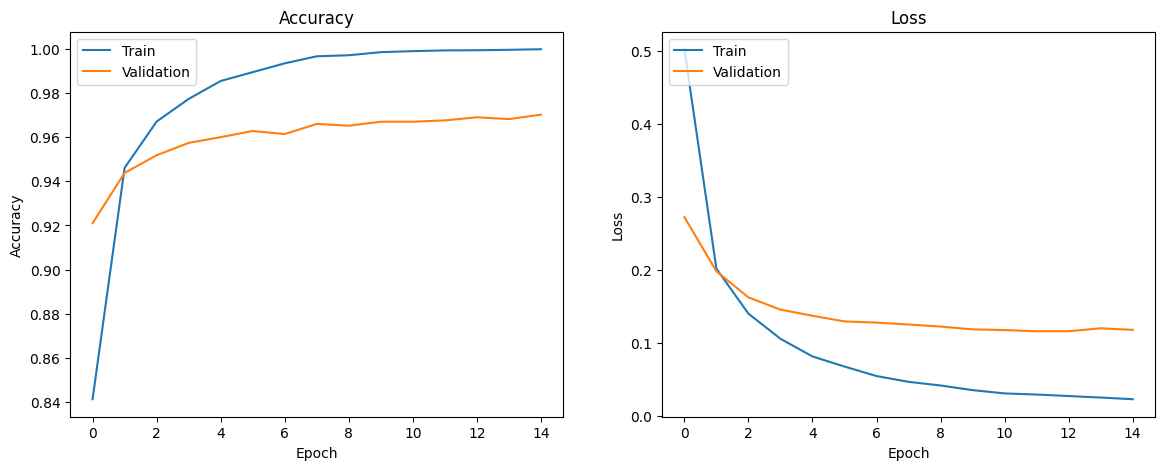

In [41]:
# Plot training & validation Loss - Accuracy values
loss_acc_graphs(history)

157/157 [==============================] - 6s 36ms/step


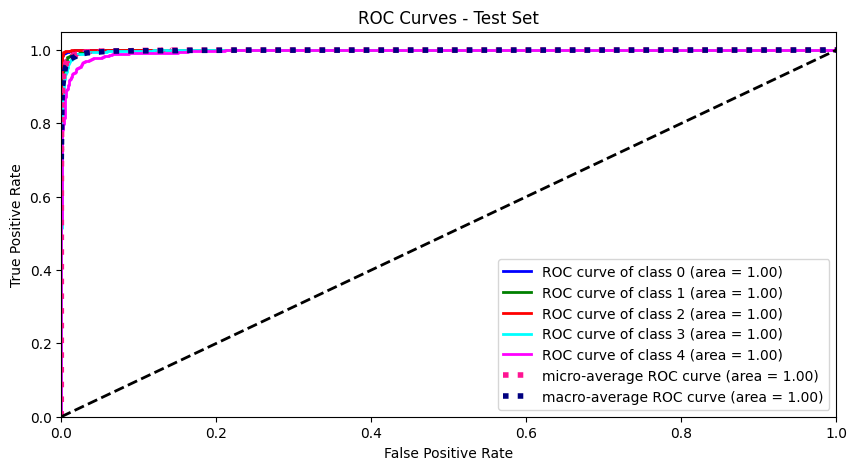

In [42]:
# ---------------- ROC Curve for Test set ----------------

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

y_score_test = model.predict(X_test)
#number of classes
n_classes = y_test.shape[1]
plot_roc_curves(y_test, y_score_test, n_classes, title='ROC Curves - Test Set')


Confusion Matrix - Test Set Accuracy: 0.970


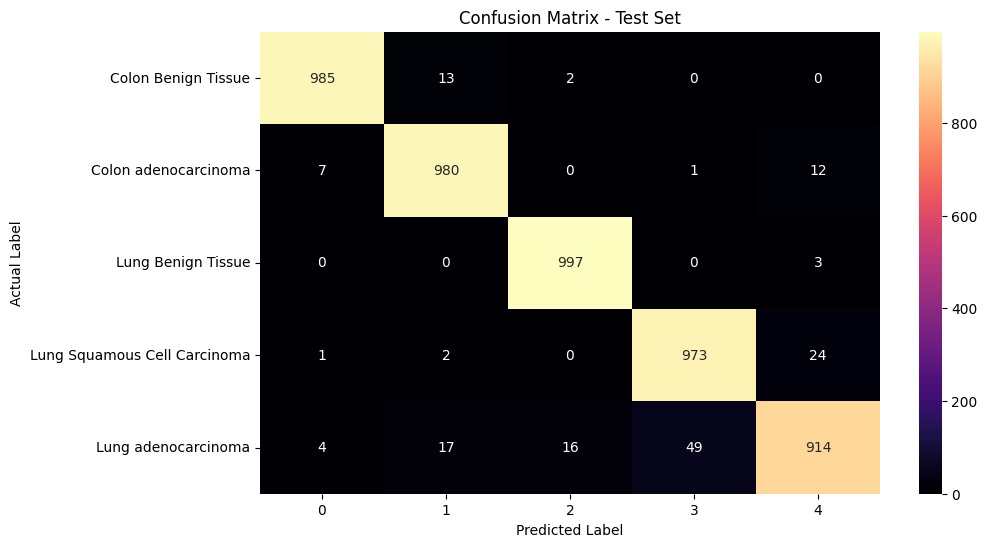

In [43]:
# ----------- Confusion Matrix for Test Set -----------

y_pred = (y_score_test > 0.5)
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, title='Confusion Matrix - Test Set')

In [44]:
# Evaluation Metrics for test set
precision_test, recall_test, f1_test = calculate_metrics(y_test, y_score_test)
print(f'Test - Precision: {precision_test:.3f}, Recall: {recall_test:.3f}, F1 Score: {f1_test:.3f}')

Test - Precision: 0.970, Recall: 0.970, F1 Score: 0.970


## **The following are not part of the final results but just experiments we had, so we can find the best parameters**


In [ ]:
""" # adding l2 = 0.0001

from tensorflow.keras import Sequential, layers, regularizers
# Create a sequential model
l2_model = Sequential()
regularizer = regularizers.l2(0.0001)

# Add convolutional and pooling layers
#we will use padding="same" so our width and height remain the same
l2_model.add(layers.Conv2D(128, (3,3), activation="relu", input_shape = X_train.shape[1:], padding='same', kernel_regularizer = regularizer)) #input shape is (120, 120, 3) which is height x width x channels
l2_model.add(layers.MaxPooling2D((2,2)) )
l2_model.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
l2_model.add(layers.MaxPooling2D((2,2)) )
l2_model.add(layers.Flatten())
l2_model.add(layers.Dense(128, activation = "relu", kernel_regularizer = regularizer ))
l2_model.add(layers.Dense(32, activation = "relu", kernel_regularizer = regularizer ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
l2_model.add(layers.Dense(5, activation='softmax'))


l2_model.summary()



 """

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 57600)             0         
                                                                 
 dense_9 (Dense)             (None, 128)              

Epoch 1/10
469/469 [==============================] - 18s 36ms/step - loss: 4.0844 - accuracy: 0.6023 - val_loss: 0.8955 - val_accuracy: 0.7304
Epoch 2/10
469/469 [==============================] - 16s 34ms/step - loss: 0.9122 - accuracy: 0.7159 - val_loss: 0.8600 - val_accuracy: 0.7580
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - loss: 0.8063 - accuracy: 0.7584 - val_loss: 0.7972 - val_accuracy: 0.7736
Epoch 4/10
469/469 [==============================] - 16s 34ms/step - loss: 0.7628 - accuracy: 0.7739 - val_loss: 0.7778 - val_accuracy: 0.7624
Epoch 5/10
469/469 [==============================] - 16s 34ms/step - loss: 0.7080 - accuracy: 0.7959 - val_loss: 0.7450 - val_accuracy: 0.7854
Epoch 6/10
469/469 [==============================] - 17s 37ms/step - loss: 0.7688 - accuracy: 0.7903 - val_loss: 0.8744 - val_accuracy: 0.7566
Epoch 7/10
469/469 [==============================] - 16s 33ms/step - loss: 0.7418 - accuracy: 0.7969 - val_loss: 0.7631 - val_accuracy:

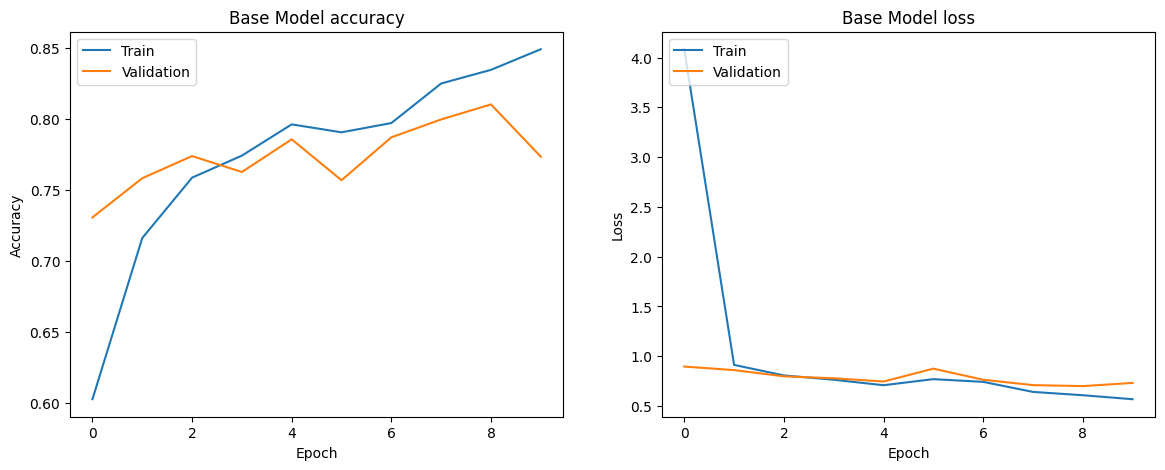

In [ ]:
""" l2_model.compile(optimizer="Adam", metrics = ["accuracy"], loss="categorical_crossentropy" )
l2_model_hist = l2_model.fit(X_train, y_train, epochs= 10, batch_size = 32, validation_data = (X_val, y_val) )
test_loss, test_acc = l2_model.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(l2_model_hist)

 """

In [ ]:
""" # model 3 (using drop out for fighting overfitting)
from tensorflow.keras import Sequential, layers, regularizers
# Create a sequential model

model_drop = Sequential()
# Add convolutional and pooling layers
#we will use padding="same" so our width and height remain the same
model_drop.add(layers.Conv2D(128, (3,3), activation="relu", input_shape = X_train.shape[1:], padding='same')) #input shape is (120, 120, 3) which is height x width x channels
model_drop.add(layers.MaxPooling2D((2,2)) )
model_drop.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same'))
model_drop.add(layers.MaxPooling2D((2,2)) )
model_drop.add(layers.Flatten())

model_drop.add(layers.Dropout(0.3))
model_drop.add(layers.Dense(128, activation = "relu" ))

model_drop.add(layers.Dropout(0.3))
model_drop.add(layers.Dense(32, activation = "relu" ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
model_drop.add(layers.Dropout(0.3))
model_drop.add(layers.Dense(5, activation='softmax'))


model_drop.summary() """

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 57600)             0         
                                                                 
 dropout_3 (Dropout)         (None, 57600)            

Epoch 1/10
469/469 [==============================] - 17s 34ms/step - loss: 2.4669 - accuracy: 0.4952 - val_loss: 1.0595 - val_accuracy: 0.5300
Epoch 2/10
469/469 [==============================] - 15s 33ms/step - loss: 0.8961 - accuracy: 0.5581 - val_loss: 0.7182 - val_accuracy: 0.6034
Epoch 3/10
469/469 [==============================] - 15s 33ms/step - loss: 0.7730 - accuracy: 0.5859 - val_loss: 0.6987 - val_accuracy: 0.6102
Epoch 4/10
469/469 [==============================] - 17s 36ms/step - loss: 0.7471 - accuracy: 0.5913 - val_loss: 0.8647 - val_accuracy: 0.5732
Epoch 5/10
469/469 [==============================] - 16s 33ms/step - loss: 0.7346 - accuracy: 0.6036 - val_loss: 0.6722 - val_accuracy: 0.6464
Epoch 6/10
469/469 [==============================] - 15s 33ms/step - loss: 0.7160 - accuracy: 0.6169 - val_loss: 0.6634 - val_accuracy: 0.6524
Epoch 7/10
469/469 [==============================] - 15s 33ms/step - loss: 0.7242 - accuracy: 0.6094 - val_loss: 0.6574 - val_accuracy:

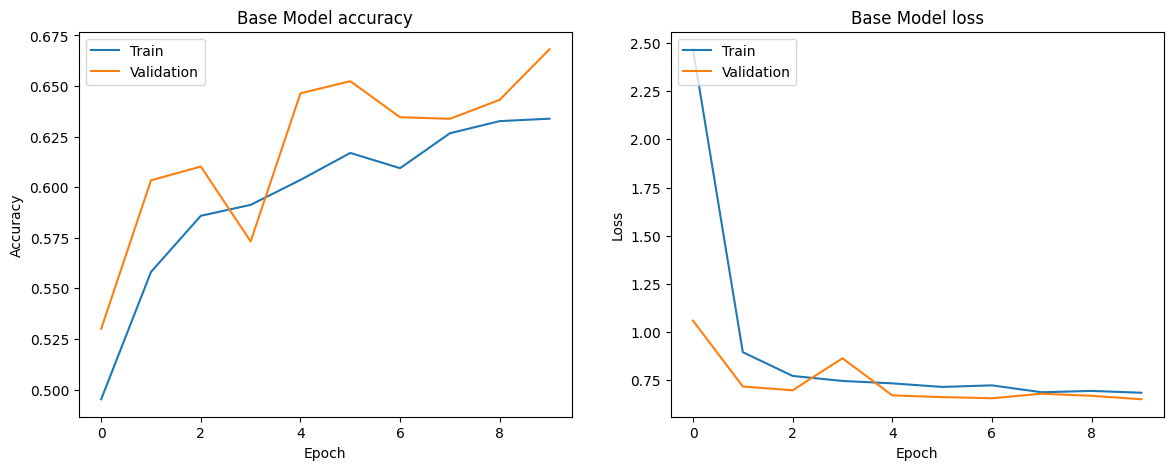

In [ ]:
""" model_drop.compile(optimizer="Adam", metrics = ["accuracy"], loss="categorical_crossentropy" )
model_drop_hist = model_drop.fit(X_train, y_train, epochs= 10, batch_size = 32, validation_data = (X_val, y_val) )
test_loss, test_acc = model_drop.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_drop_hist)

 """

In [ ]:
""" # l2 wich copes best with overfitting, now we will add learning rate and adamax optimizer

from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Create a sequential model
l2_model_lr = Sequential()
regularizer = regularizers.l2(0.0001)

# Add convolutional and pooling layers
#we will use padding="same" so our width and height remain the same
l2_model_lr.add(layers.Conv2D(128, (3,3), activation="relu", input_shape = X_train.shape[1:], padding='same', kernel_regularizer = regularizer)) #input shape is (120, 120, 3) which is height x width x channels
l2_model_lr.add(layers.MaxPooling2D((2,2)) )
l2_model_lr.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
l2_model_lr.add(layers.MaxPooling2D((2,2)) )
l2_model_lr.add(layers.Flatten())
l2_model_lr.add(layers.Dense(128, activation = "relu", kernel_regularizer = regularizer ))
l2_model_lr.add(layers.Dense(32, activation = "relu", kernel_regularizer = regularizer ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
l2_model_lr.add(layers.Dense(5, activation='softmax'))


l2_model_lr.summary() """

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 60, 60, 64)        73792     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 57600)             0         
                                                                 
 dense_12 (Dense)            (None, 128)              

Epoch 1/20
469/469 [==============================] - 20s 37ms/step - loss: 1.4361 - accuracy: 0.6171 - val_loss: 1.0168 - val_accuracy: 0.6462
Epoch 2/20
469/469 [==============================] - 17s 37ms/step - loss: 0.6275 - accuracy: 0.7649 - val_loss: 0.6558 - val_accuracy: 0.7352
Epoch 3/20
469/469 [==============================] - 16s 35ms/step - loss: 0.4842 - accuracy: 0.8133 - val_loss: 0.4684 - val_accuracy: 0.8154
Epoch 4/20
469/469 [==============================] - 18s 38ms/step - loss: 0.4149 - accuracy: 0.8423 - val_loss: 0.3501 - val_accuracy: 0.8750
Epoch 5/20
469/469 [==============================] - 16s 35ms/step - loss: 0.3499 - accuracy: 0.8689 - val_loss: 0.3466 - val_accuracy: 0.8728
Epoch 6/20
469/469 [==============================] - 18s 37ms/step - loss: 0.3039 - accuracy: 0.8865 - val_loss: 0.3440 - val_accuracy: 0.8692
Epoch 7/20
469/469 [==============================] - 17s 36ms/step - loss: 0.2528 - accuracy: 0.9086 - val_loss: 0.2932 - val_accuracy:

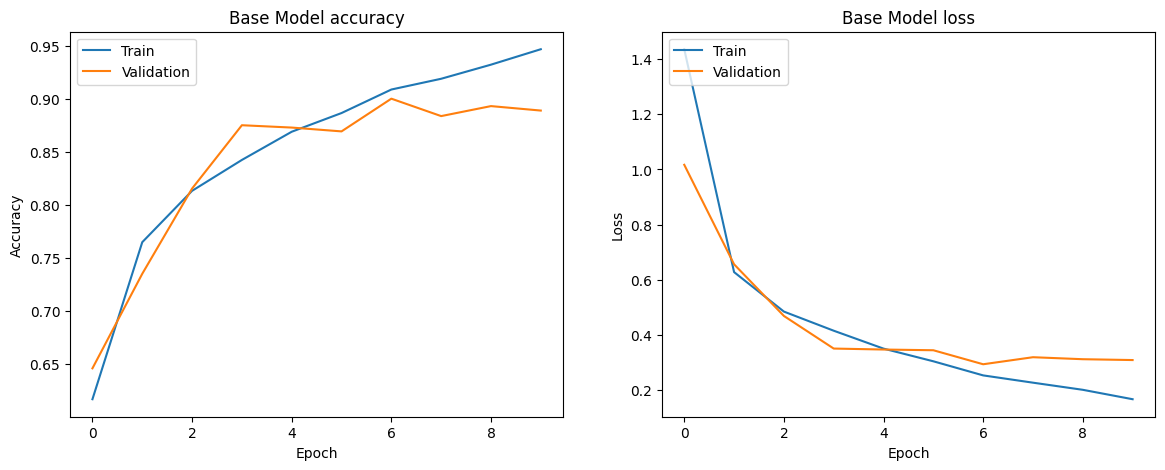

In [ ]:
""" from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0001)

l2_model_lr.compile(optimizer=adam_optimizer, metrics = ["accuracy"], loss="categorical_crossentropy" )
l2_model_lr_hist = l2_model_lr.fit(X_train, y_train, epochs= 20, batch_size = 32, validation_data = (X_val, y_val), callbacks=[early_stopping] )
test_loss, test_acc = l2_model_lr.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(l2_model_lr_hist)

 """

In [ ]:
""" # after using l2 and cope with overfiting we will try to improve accurcy by making the model more complex by adding more neurons

from tensorflow.keras import Sequential, layers, regularizers
# Create a sequential model
model_extra_layers = Sequential()
regularizer = regularizers.l2(0.0001)

# Add convolutional and pooling layers
#we will use padding="same" so our width and height remain the same
model_extra_layers.add(layers.Conv2D(128, (3,3), activation="relu", input_shape = X_train.shape[1:], padding='same', kernel_regularizer = regularizer)) #input shape is (120, 120, 3) which is height x width x channels
model_extra_layers.add(layers.MaxPooling2D((2,2)) )
model_extra_layers.add(layers.Conv2D(256, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
model_extra_layers.add(layers.MaxPooling2D((2,2)) )
model_extra_layers.add(layers.Flatten())
model_extra_layers.add(layers.Dense(256, activation = "relu", kernel_regularizer = regularizer ))
model_extra_layers.add(layers.Dense(64, activation = "relu", kernel_regularizer = regularizer ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
model_extra_layers.add(layers.Dense(5, activation='softmax'))


model_extra_layers.summary() """

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     3584      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 256)       295168    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 256)       0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 230400)            0         
                                                                 
 dense_3 (Dense)             (None, 256)              

In [ ]:
""" model_extra_layers.compile(optimizer="Adam", metrics = ["accuracy"], loss="categorical_crossentropy" )
model_extra_layers_hist = model_extra_layers.fit(X_train, y_train, epochs= 10, batch_size = 32, validation_data = (X_val, y_val) )

 """

Epoch 1/10
469/469 [==============================] - 36s 74ms/step - loss: 21.1669 - accuracy: 0.5921 - val_loss: 0.7332 - val_accuracy: 0.7126
Epoch 2/10
469/469 [==============================] - 34s 73ms/step - loss: 0.7314 - accuracy: 0.7109 - val_loss: 0.6484 - val_accuracy: 0.7578
Epoch 3/10
469/469 [==============================] - 35s 74ms/step - loss: 0.6501 - accuracy: 0.7505 - val_loss: 0.6487 - val_accuracy: 0.7572
Epoch 4/10
469/469 [==============================] - 34s 73ms/step - loss: 0.6669 - accuracy: 0.7605 - val_loss: 0.7050 - val_accuracy: 0.7068
Epoch 5/10
469/469 [==============================] - 34s 73ms/step - loss: 0.5995 - accuracy: 0.7859 - val_loss: 0.6617 - val_accuracy: 0.7676
Epoch 6/10
469/469 [==============================] - 34s 73ms/step - loss: 0.7702 - accuracy: 0.7519 - val_loss: 2.2300 - val_accuracy: 0.2000
Epoch 7/10
469/469 [==============================] - 34s 73ms/step - loss: 1.7666 - accuracy: 0.2065 - val_loss: 1.7491 - val_accuracy

AttributeError: 'History' object has no attribute 'evaluate'

157/157 [==============================] - 3s 16ms/step - loss: 1.3484 - accuracy: 0.3800


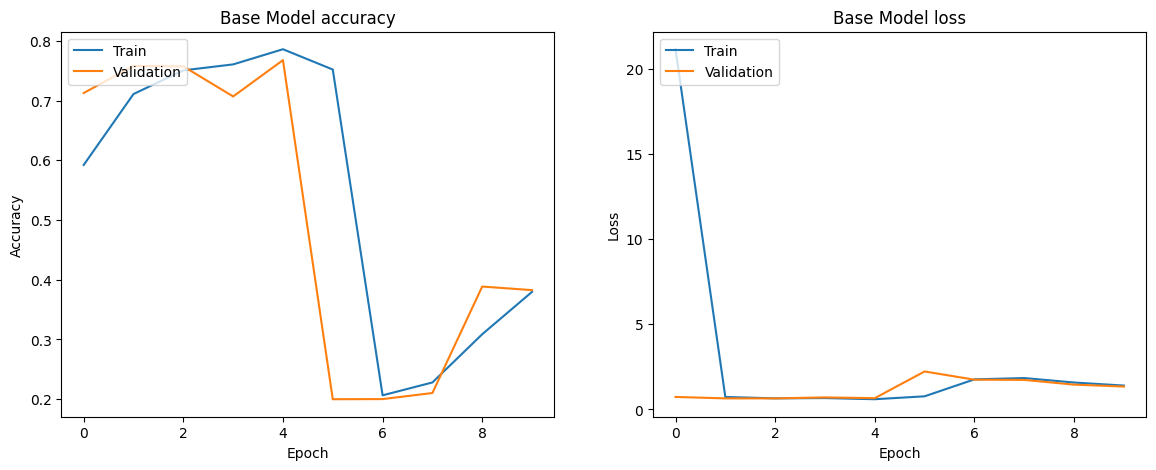

In [ ]:
""" test_loss, test_acc = model_extra_layers.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_extra_layers_hist)
 """

In [ ]:
""" #we will try to improve the model by adding CNN layers

from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

# Create a sequential model
model_layers = Sequential()
regularizer = regularizers.l2(0.0001)

# Add convolutional and pooling layers

model_layers.add(layers.Conv2D(128, (3,3), activation="relu", input_shape = X_train.shape[1:], padding='same', kernel_regularizer = regularizer)) #input shape is (120, 120, 3) which is height x width x channels
model_layers.add(layers.Conv2D(128, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Flatten())
model_layers.add(layers.Dense(128, activation = "relu", kernel_regularizer = regularizer ))
model_layers.add(layers.Dense(32, activation = "relu", kernel_regularizer = regularizer ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
model_layers.add(layers.Dense(5, activation='softmax'))


model_layers.summary() """

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 120, 120, 128)     3584      
                                                                 
 conv2d_15 (Conv2D)          (None, 120, 120, 128)     147584    
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 60, 60, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 60, 60, 64)        73792     
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                                

Epoch 1/20
469/469 [==============================] - 56s 111ms/step - loss: 0.7901 - accuracy: 0.7069 - val_loss: 0.4942 - val_accuracy: 0.8168
Epoch 2/20
469/469 [==============================] - 49s 106ms/step - loss: 0.4315 - accuracy: 0.8431 - val_loss: 0.4281 - val_accuracy: 0.8506
Epoch 3/20
469/469 [==============================] - 50s 108ms/step - loss: 0.3498 - accuracy: 0.8802 - val_loss: 0.3790 - val_accuracy: 0.8838
Epoch 4/20
469/469 [==============================] - 51s 108ms/step - loss: 0.2701 - accuracy: 0.9144 - val_loss: 0.2684 - val_accuracy: 0.9260
Epoch 5/20
469/469 [==============================] - 50s 107ms/step - loss: 0.2138 - accuracy: 0.9406 - val_loss: 0.2981 - val_accuracy: 0.8904
Epoch 6/20
469/469 [==============================] - 51s 108ms/step - loss: 0.1698 - accuracy: 0.9583 - val_loss: 0.1741 - val_accuracy: 0.9544
Epoch 7/20
469/469 [==============================] - 51s 108ms/step - loss: 0.1400 - accuracy: 0.9683 - val_loss: 0.2748 - val_ac

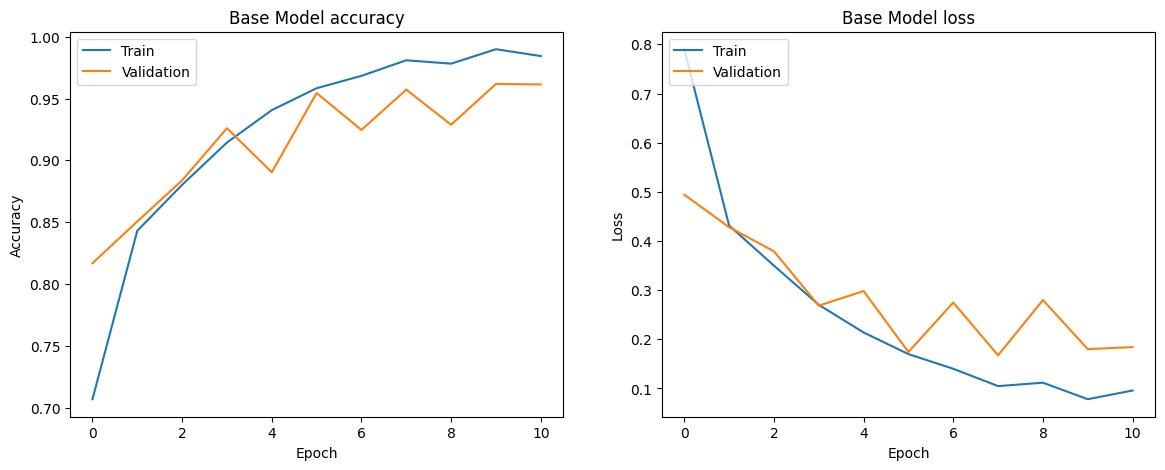

In [ ]:
""" from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0001)

model_layers.compile(optimizer=adam_optimizer, metrics = ["accuracy"], loss="categorical_crossentropy" )
model_layers_hist = model_layers.fit(X_train, y_train, epochs= 20, batch_size = 32, validation_data = (X_val, y_val), callbacks=[early_stopping] )
test_loss, test_acc = model_layers.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_layers_hist)

 """

In [ ]:
""" #we will try to improve the model by adding more NEURONS

from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Create a sequential model
model_layers = Sequential()
regularizer = regularizers.l2(0.0001)

# Add convolutional and pooling layers

model_layers.add(layers.Conv2D(64, (3,3), activation="tanh", input_shape = X_train.shape[1:], padding='same', kernel_regularizer = regularizer)) #input shape is (120, 120, 3) which is height x width x channels
model_layers.add(layers.Conv2D(64, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(128, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(128, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(512, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(512, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.Conv2D(256, (3,3), activation = "tanh", padding='same', kernel_regularizer = regularizer ))
model_layers.add(layers.MaxPooling2D((2,2)) )

model_layers.add(layers.Flatten())
model_layers.add(layers.Dense(128, activation = "tanh", kernel_regularizer = regularizer ))
model_layers.add(layers.Dense(64, activation = "tanh", kernel_regularizer = regularizer ))
#for the ouput layer we are going to use softmax as an activation function as we have a multi-class classification problem (5 classes).
model_layers.add(layers.Dense(5, activation='softmax'))


model_layers.summary() """

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 120, 120, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 128)       0         
 g2D)                                                   

Epoch 1/20
469/469 [==============================] - 81s 144ms/step - loss: 0.6764 - accuracy: 0.8255 - val_loss: 0.5067 - val_accuracy: 0.8924
Epoch 2/20
469/469 [==============================] - 57s 122ms/step - loss: 0.5422 - accuracy: 0.8871 - val_loss: 0.5189 - val_accuracy: 0.8858
Epoch 3/20
469/469 [==============================] - 62s 132ms/step - loss: 0.4859 - accuracy: 0.9091 - val_loss: 0.4815 - val_accuracy: 0.9124
Epoch 4/20
469/469 [==============================] - 63s 134ms/step - loss: 0.4392 - accuracy: 0.9261 - val_loss: 0.4400 - val_accuracy: 0.9262
Epoch 5/20
469/469 [==============================] - 63s 134ms/step - loss: 0.4045 - accuracy: 0.9377 - val_loss: 0.3891 - val_accuracy: 0.9424
Epoch 6/20
469/469 [==============================] - 59s 126ms/step - loss: 0.3647 - accuracy: 0.9531 - val_loss: 0.3368 - val_accuracy: 0.9656
Epoch 7/20
469/469 [==============================] - 59s 125ms/step - loss: 0.3298 - accuracy: 0.9649 - val_loss: 0.4989 - val_ac

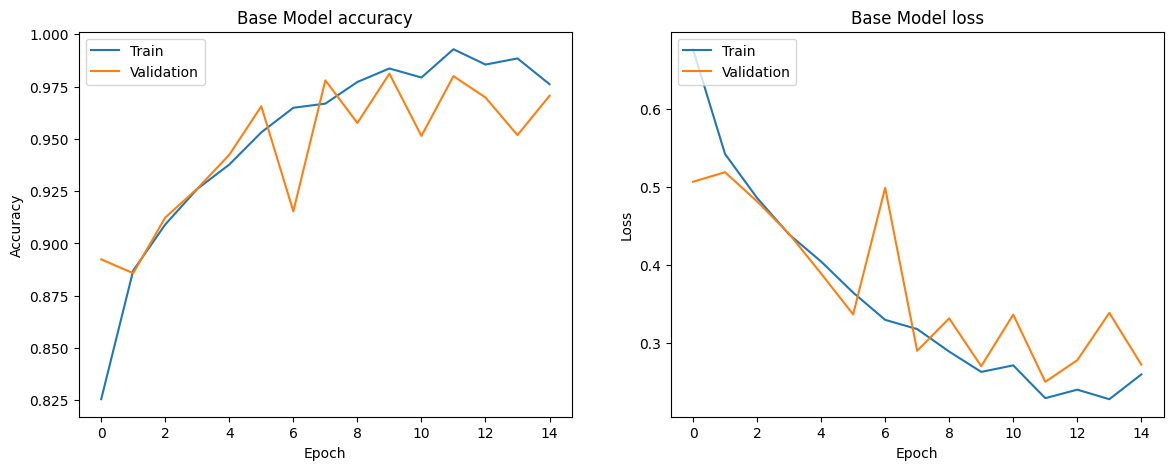

In [ ]:
""" from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0001)

model_layers.compile(optimizer=adam_optimizer, metrics = ["accuracy"], loss="categorical_crossentropy" )
model_layers_hist = model_layers.fit(X_train, y_train, epochs= 20, batch_size = 32, validation_data = (X_val, y_val), callbacks=[early_stopping] )
test_loss, test_acc = model_layers.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_layers_hist) """

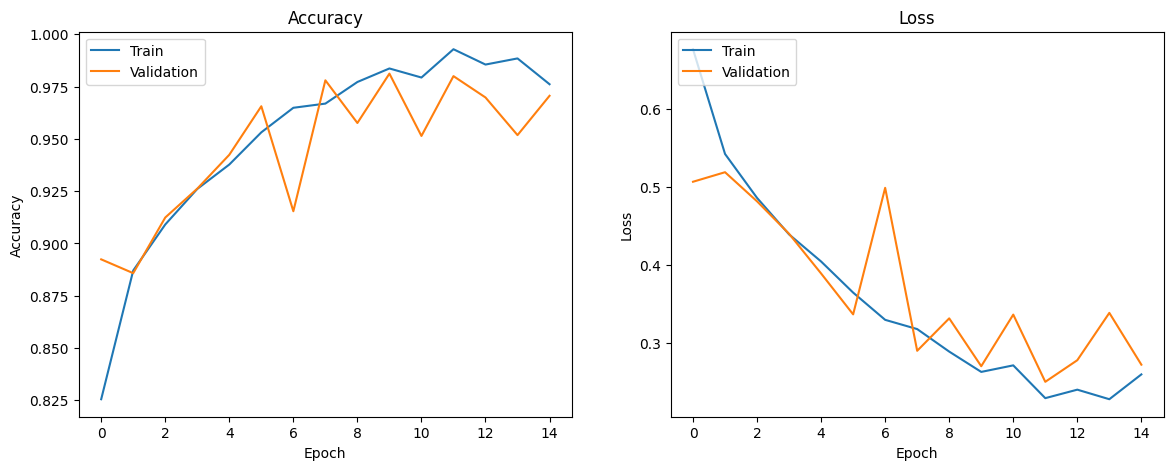

In [ ]:
""" # Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_layers_hist) """

157/157 [==============================] - 6s 35ms/step


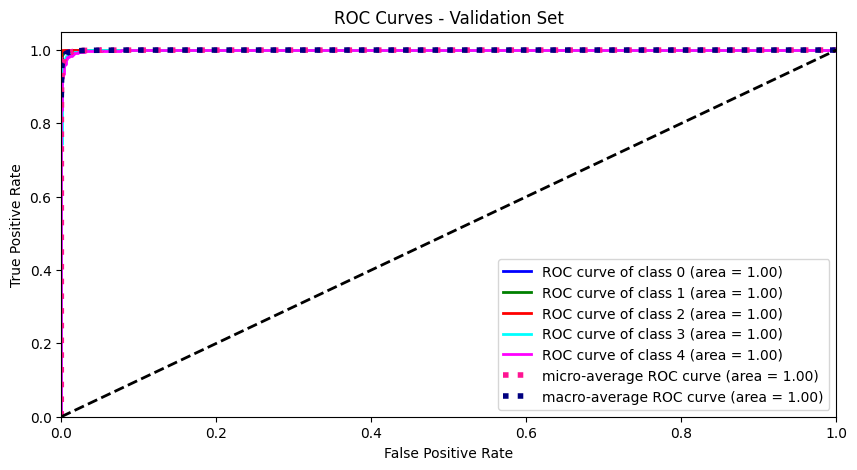

In [ ]:
""" # ---------------- ROC Curve for validation set ----------------

# calculating the predicted probabilities for each class
y_score_val = model_layers.predict(X_val)
#number of classes
n_classes = y_val.shape[1]

plot_roc_curves(y_val, y_score_val, n_classes, title='ROC Curves - Validation Set')
#AUC values range from 0 to 1, with a higher AUC indicating a better model performance """

157/157 [==============================] - 6s 36ms/step


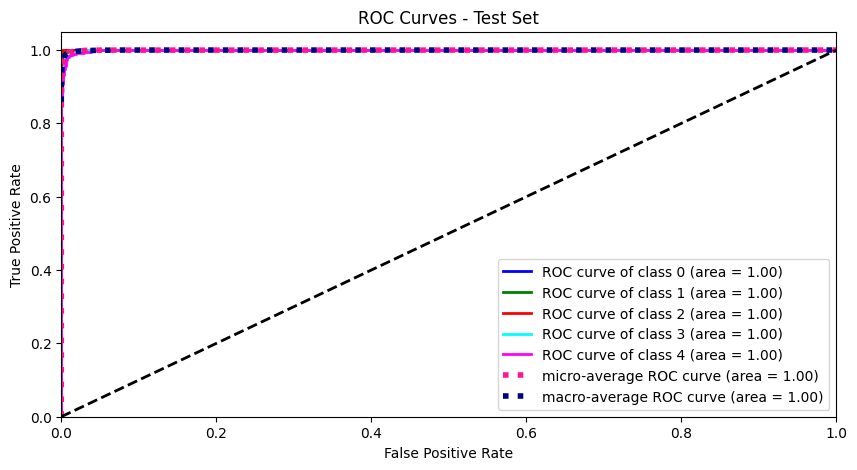

In [ ]:
""" # ---------------- ROC Curve for Test set ----------------

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

y_score_test = model_layers.predict(X_test)
#number of classes
n_classes = y_test.shape[1]
plot_roc_curves(y_test, y_score_test, n_classes, title='ROC Curves - Test Set')
 """

Confusion Matrix - Validation Set Accuracy: 0.980


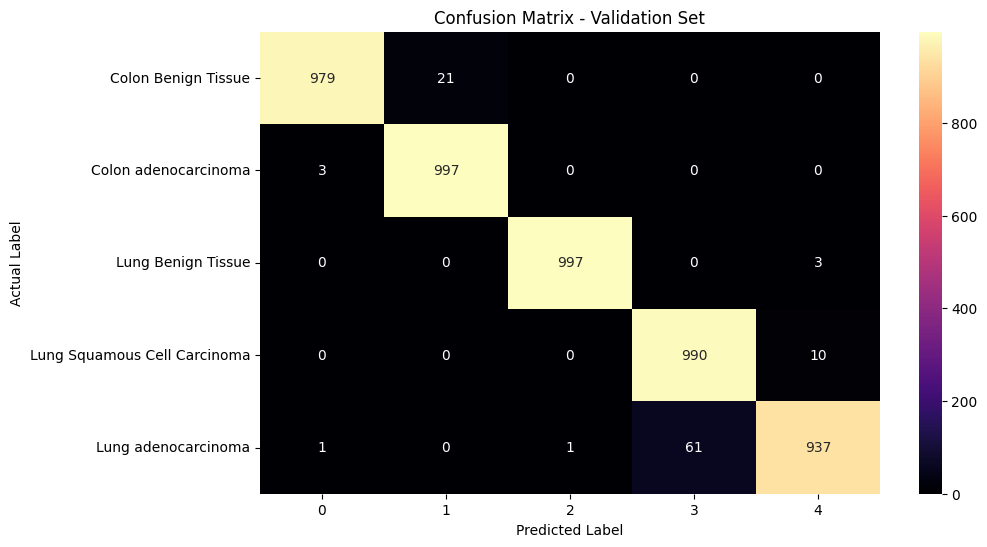

In [ ]:
""" # ----------- Confusion Matrix for Validation Set -----------

y_pred = (y_score_val > 0.5)
plot_confusion_matrix(y_val, y_pred, label_encoder.classes_, title='Confusion Matrix - Validation Set') """

Confusion Matrix - Test Set Accuracy: 0.980


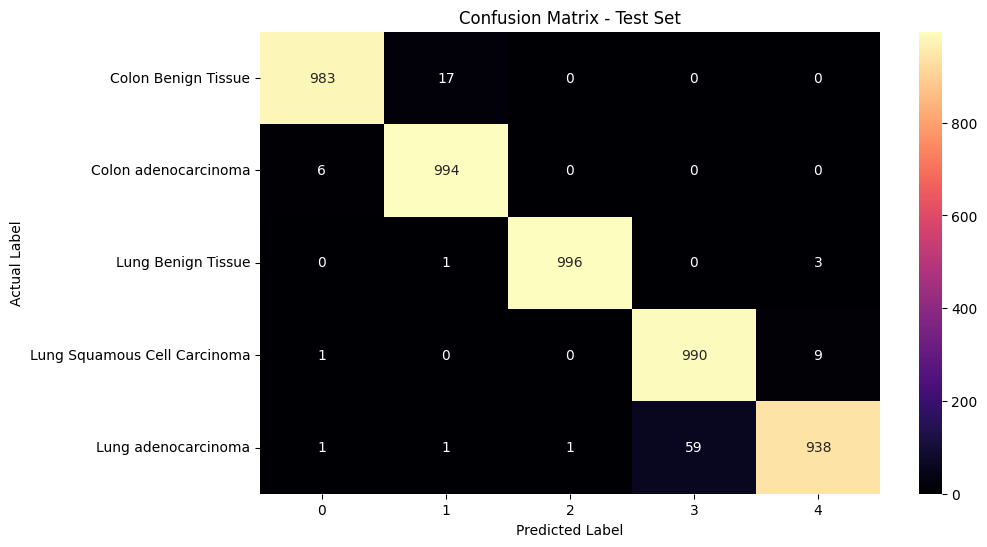

In [ ]:
""" # ----------- Confusion Matrix for Test Set -----------

y_pred = (y_score_test > 0.5)
plot_confusion_matrix(y_test, y_pred, label_encoder.classes_, title='Confusion Matrix - Test Set') """

In [ ]:
""" # best model so far but we will try again drop out instead of l2


from tensorflow.keras import Sequential, layers
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Create a sequential model
model_layers = Sequential()

# Add convolutional and pooling layers with dropout
model_layers.add(layers.Conv2D(64, (3,3), activation="relu", input_shape = X_train.shape[1:], padding='same'))
model_layers.add(layers.Conv2D(64, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.MaxPooling2D((2,2)))
model_layers.add(layers.Dropout(0.25))

model_layers.add(layers.Conv2D(128, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.Conv2D(128, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.MaxPooling2D((2,2)))
model_layers.add(layers.Dropout(0.25))

model_layers.add(layers.Conv2D(256, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.Conv2D(256, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.MaxPooling2D((2,2)))
model_layers.add(layers.Dropout(0.25))

model_layers.add(layers.Conv2D(512, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.Conv2D(512, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.MaxPooling2D((2,2)))
model_layers.add(layers.Dropout(0.25))

model_layers.add(layers.Conv2D(256, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.Conv2D(256, (3,3), activation = "relu", padding='same'))
model_layers.add(layers.MaxPooling2D((2,2)))
model_layers.add(layers.Dropout(0.25))

model_layers.add(layers.Flatten())
model_layers.add(layers.Dense(128, activation = "relu"))
model_layers.add(layers.Dropout(0.25))
model_layers.add(layers.Dense(64, activation = "relu"))
model_layers.add(layers.Dropout(0.25))

# For the output layer we are going to use softmax as we have a multi-class classification problem (5 classes).
model_layers.add(layers.Dense(5, activation='softmax'))

model_layers.summary()
 """

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_71 (Conv2D)          (None, 120, 120, 64)      1792      
                                                                 
 conv2d_72 (Conv2D)          (None, 120, 120, 64)      36928     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 60, 60, 64)        0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 60, 60, 64)        0         
                                                                 
 conv2d_73 (Conv2D)          (None, 60, 60, 128)       73856     
                                                                 
 conv2d_74 (Conv2D)          (None, 60, 60, 128)       147584    
                                                     

Epoch 1/20
469/469 [==============================] - 72s 142ms/step - loss: 1.1774 - accuracy: 0.4718 - val_loss: 0.8947 - val_accuracy: 0.6298
Epoch 2/20
469/469 [==============================] - 64s 137ms/step - loss: 0.5696 - accuracy: 0.7694 - val_loss: 0.5623 - val_accuracy: 0.7474
Epoch 3/20
469/469 [==============================] - 64s 136ms/step - loss: 0.4378 - accuracy: 0.8323 - val_loss: 0.3352 - val_accuracy: 0.8822
Epoch 4/20
469/469 [==============================] - 64s 136ms/step - loss: 0.3479 - accuracy: 0.8669 - val_loss: 0.2411 - val_accuracy: 0.9168
Epoch 5/20
469/469 [==============================] - 63s 135ms/step - loss: 0.2400 - accuracy: 0.9130 - val_loss: 0.1862 - val_accuracy: 0.9220
Epoch 6/20
469/469 [==============================] - 64s 136ms/step - loss: 0.2125 - accuracy: 0.9238 - val_loss: 0.1426 - val_accuracy: 0.9486
Epoch 7/20
469/469 [==============================] - 63s 134ms/step - loss: 0.1858 - accuracy: 0.9324 - val_loss: 0.2064 - val_ac

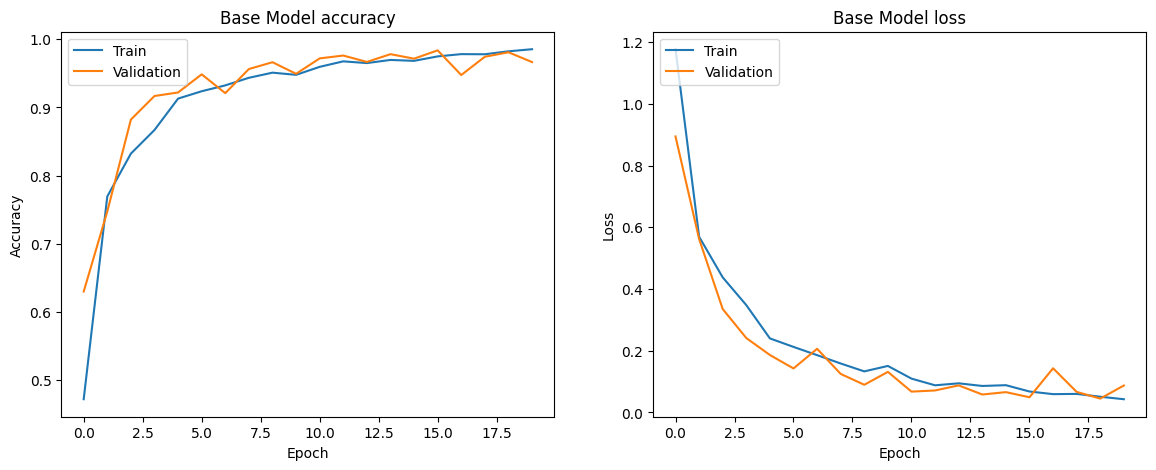

In [ ]:
""" from tensorflow.keras.optimizers import Adam

adam_optimizer = Adam(learning_rate=0.0001)

model_layers.compile(optimizer=adam_optimizer, metrics = ["accuracy"], loss="categorical_crossentropy" )
model_layers_hist = model_layers.fit(X_train, y_train, epochs= 20, batch_size = 32, validation_data = (X_val, y_val), callbacks=[early_stopping] )
test_loss, test_acc = model_layers.evaluate(X_test, y_test)

# Plot training & validation Loss - Accuracy values
loss_acc_graphs(model_layers_hist)

 """